In [49]:
import os
import json
import string
import random
import pickle
import nltk
import numpy as np
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import load_model
nltk.download("punkt")
nltk.download("wordnet")

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ACER\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Chatbot

In [50]:
class ChatBot:
    """
    A class for creating a chatbot.

    Attributes:
        intents (dict): A dictionary of intents, where each intent is a dictionary with the following keys:
            * patterns (list): A list of patterns that the intent matches.
            * tag (str): The name of the intent.
        all_words (list): A list of all the words in the intents.
        classes (list): A list of all the intent tags.
        dataset (list): A list of tuples, where each tuple consists of a list of tokenized words and the intent tag.
        language (str): Language of the chatbot
        mode (str): Chatbot running modes
                        - development : Debugging logs will be enabled
                        - production : Debugging logs will be disabled

    Methods:
        preprocess(): Preprocesses the intents, creating the all_words and classes lists.
        create_pkl_files(): Creates the `all_words.pkl` and `classes.pkl` files.
        gen_graph(hist, title): Plots the accuracy and loss graphs for the training history.
        get_train_set(): Creates a training set from the dataset list.
        xy_split(train_set): Splits the training set into the x and y components.
        create_model(input_shape, output_shape): Creates a Keras model for training.
        train(epochs=200): Trains the Keras model.
        clean_up(sentence): Cleans up a sentence, removing punctuation and stemming the words.
        bag_of_words(sentence): Creates a bag-of-words representation of a sentence.
    """
    def __init__(self, language='en'):
        self.intents = None
        self.language = language
        self.lm = WordNetLemmatizer()
        self.classes = []
        self.vocab = []
        self.training_data = []
        self.model = None
        self.mode = 'development'

    def load_intents(self):
        # Load intents data from JSON file based on the specified language
        intents_file = f'./dataset/intents_{self.language}.json'
        with open(intents_file, 'r', encoding='utf-8') as f:
            self.intents = json.load(f)

    def prepare_data(self):
        """
        Load and preprocess intent data for training the chatbot.
            Args:
            intents_data (dict): A dictionary containing intent data with tags, patterns, and responses.
        Returns:
            None
        """
        # load intents file
        self.load_intents()
        # Get unique intent tags and sort them
        self.classes = sorted(set(intent["tag"] for intent in self.intents["intents"]))

        # Process patterns and build vocabulary and training data
        for intent in self.intents["intents"]:
            for pattern in intent["patterns"]:
                # Tokenize pattern text into individual words
                tokens = nltk.word_tokenize(pattern)

                if self.language == 'en':
                    # Lemmatize words and convert to lowercase, excluding punctuation
                    tokens = [self.lm.lemmatize(word.lower()) for word in tokens if word not in string.punctuation]
                else:
                    tokens = [word for word in tokens if word not in string.punctuation]

                # Extend vocabulary with processed tokens
                self.vocab.extend(tokens)
                # Store tokenized pattern and associated intent tag in training data
                self.training_data.append((tokens, intent["tag"]))

        # Remove duplicates and sort vocabulary
        self.vocab = sorted(set(self.vocab))
        # save vocab and classes
        self.save_data()

    def save_data(self):
        # Save the vocabulary and classes as pickle files
        vocab_path = f'./saved_data/chatbot_{self.language}/vocab.pkl'
        classes_path = f'./saved_data/chatbot_{self.language}/classes.pkl'
        with open(vocab_path, 'wb') as f:
            pickle.dump(self.vocab, f)
        with open(classes_path, 'wb') as f:
            pickle.dump(self.classes, f)

    def load_model_and_data(self):
        self.load_intents()
        self.vocab = self.load_pkl_file('./saved_data/chatbot_{}/vocab.pkl'.format(self.language))
        self.classes = self.load_pkl_file('./saved_data/chatbot_{}/classes.pkl'.format(self.language))
        self.model = load_model(f'./saved_data/chatbot_{self.language}/model')

    def load_pkl_file(self, file_path):
        with open(file_path, 'rb') as f:
            data = pickle.load(f)
        return data

    def create_model(self):
        """
        Create and compile the deep learning model for intent classification.
        Returns:
            history: Training history of the model.
        """
        # Prepare training data
        x_train = []
        y_train = []

        for (tokens, intent_tag) in self.training_data:
            # Convert tokens to bag of words representation
            bag = [1 if word in tokens else 0 for word in self.vocab]

            # Prepare one-hot encoded output for the intent tag
            output = [0] * len(self.classes)
            output[self.classes.index(intent_tag)] = 1

            x_train.append(bag)
            y_train.append(output)

        x_train = np.array(x_train)
        y_train = np.array(y_train)

        # Define input and output shapes for the model
        i_shape = (len(x_train[0]),)
        o_shape = len(y_train[0])

        # Build the sequential model
        self.model = Sequential()
        self.model.add(Dense(128, input_shape=i_shape, activation="relu"))
        self.model.add(Dropout(0.5))
        self.model.add(Dense(64, activation="relu"))
        self.model.add(Dropout(0.3))
        self.model.add(Dense(o_shape, activation="softmax"))

        # Define learning rate schedule
        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            initial_learning_rate=0.01,
            decay_steps=10000,
            decay_rate=0.9
        )

        # Compile the model with Adam optimizer and categorical cross-entropy loss
        optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
        self.model.compile(loss="categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

        # Train the model and store training history
        hist = self.model.fit(x_train, y_train, epochs=200, verbose=1)
        if self.mode == 'development':
            self.gen_graph(hist, 'Training/loss curve')


    def preprocess_input(self, text):
        """
        Preprocess the input text by tokenizing and lemmatizing.
        Args:
            text (str): Input text to be preprocessed.
        Returns:
            preprocessed_tokens (list): List of preprocessed tokens.
        """
        # Tokenize the input text
        tokens = nltk.word_tokenize(text)
        if self.language == 'en':
            # Lemmatize each token and convert to lowercase
            tokens = [self.lm.lemmatize(word) for word in tokens]
        return tokens


    def predict_intent(self, text):
        """
        Predict the intent(s) of the given text.
        Args:
            text (str): Input text for which intent(s) are to be predicted.
        Returns:
            predicted_intents (list): List of predicted intents based on the text.
        """
        # Preprocess the input text to get tokens
        tokens = self.preprocess_input(text)
        # Create a bag of words representation based on vocabulary
        bag = [1 if word in tokens else 0 for word in self.vocab]
        # Make predictions using the model
        predictions = self.model.predict(np.array([bag]))[0]
        # Set a threshold for prediction confidence
        threshold = 0.2
        # Select intents with prediction confidence above the threshold
        predicted_intents = [self.classes[i] for i, p in enumerate(predictions) if p > threshold]
        return predicted_intents


    def generate_response(self, intent_tag):
        """
        Generate a response based on the provided intent tag.
        Args:
            intent_tag (str): Intent tag for which a response is to be generated.
        Returns:
            response (str): Randomly selected response for the provided intent tag.
        """
        # Iterate through intents in the intents data
        for intent in self.intents["intents"]:
            # Check if the current intent's tag matches the provided intent_tag
            if intent["tag"] == intent_tag:
                # Randomly select a response from the intent's responses list
                response = random.choice(intent["responses"])
                return response


    def train(self):
        """
        Train the chatbot using the provided intents data.
        Args:
            intents_data (dict): Intents data containing tags, patterns, and responses.
        Returns:
            None
        """
        # Load data from the provided intents_data and prepare
        self.prepare_data()
        # Create and train the deep learning model
        self.create_model()
        # Print a message to indicate that training is completed
        print("Training completed.")
        # Save the trained model
        model_dir = f'./saved_data/chatbot_{self.language}'
        os.makedirs(model_dir, exist_ok=True)
        model_path = os.path.join(model_dir, 'model')
        self.model.save(model_path)
        print(f"Model saved at {model_path}")


    def gen_graph(self, hist, title):
        """
        Generate a graph for model accuracy and loss.

        Args:
            hist: The history object returned from model.fit().
            title (str): The title of the graph.
        """
        plt.plot(hist.history['accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.show()

        plt.plot(hist.history['loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.show()

Training - English

In [51]:
# Initialize the chatbot and train it
chatbot = ChatBot(language='en')

Epoch 1/200
16/16 [==============================] - 0s 1ms/step - loss: 1.6364 - accuracy: 0.4607
Epoch 2/200
16/16 [==============================] - 0s 1ms/step - loss: 0.5778 - accuracy: 0.7975
Epoch 3/200
16/16 [==============================] - 0s 1ms/step - loss: 0.2551 - accuracy: 0.9421
Epoch 4/200
16/16 [==============================] - 0s 1ms/step - loss: 0.1345 - accuracy: 0.9545
Epoch 5/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0828 - accuracy: 0.9711
Epoch 6/200
16/16 [==============================] - 0s 1ms/step - loss: 0.0556 - accuracy: 0.9793

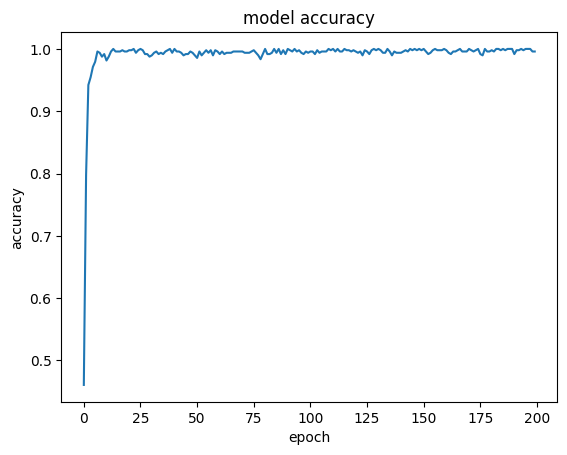

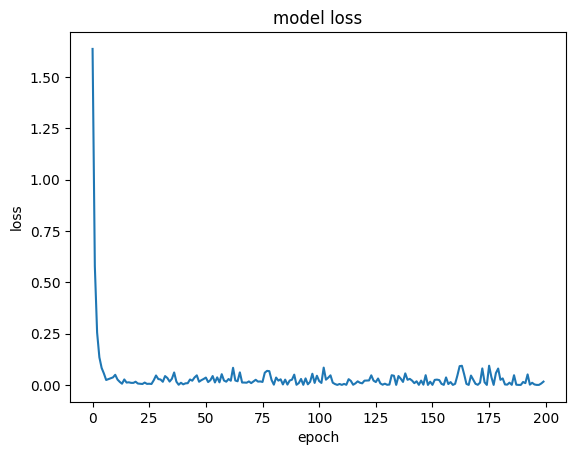

In [52]:
chatbot.train()

## Inference - English

In [53]:
chatbot_inf = ChatBot(language='en')
chatbot_inf.load_model_and_data()
# Interaction loop
while True:
    user_input = input("You: ")
    if user_input == 'q':
        break
    print(f'You: {user_input}')
    intents = chatbot_inf.predict_intent(user_input)
    print("Predicted Intents:", intents)
    if intents:
        response_intent = intents[0]
        response = chatbot_inf.generate_response(response_intent)
        print("Bot:", response)

Predicted Intents: ['greeting']
Bot: Hello! How can I assist you today?
Predicted Intents: ['goodbye']
Bot: Adios! Have a fantastic day!
Predicted Intents: ['goodbye']
Bot: Goodbye! It was nice talking to you!
Predicted Intents: ['options']
Bot: I'm here to help you with any questions or issues related to banana diseases and their management


Training - Sinhala

In [54]:
# Initialize the chatbot and train it
chatbot = ChatBot(language='si')

Epoch 1/200
15/15 [==============================] - 0s 1ms/step - loss: 1.7468 - accuracy: 0.3599
Epoch 2/200
15/15 [==============================] - 0s 1ms/step - loss: 0.7983 - accuracy: 0.7349
Epoch 3/200
15/15 [==============================] - 0s 1ms/step - loss: 0.3631 - accuracy: 0.9289
Epoch 4/200
15/15 [==============================] - 0s 1ms/step - loss: 0.1459 - accuracy: 0.9741
Epoch 5/200
15/15 [==============================] - 0s 2ms/step - loss: 0.0846 - accuracy: 0.9871
Epoch 6/200
15/15 [==============================] - 0s 1ms/step - loss: 0.0625 - accuracy: 0.9828

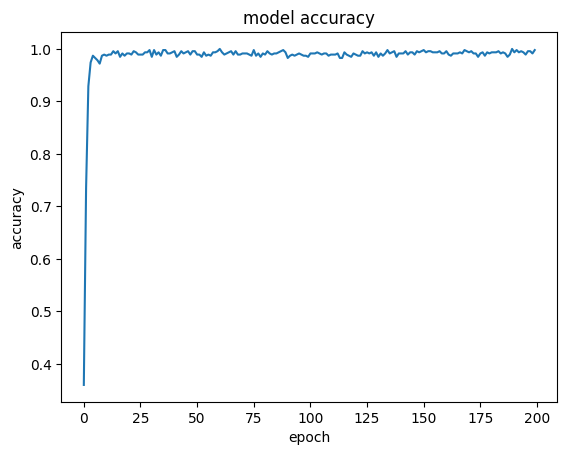

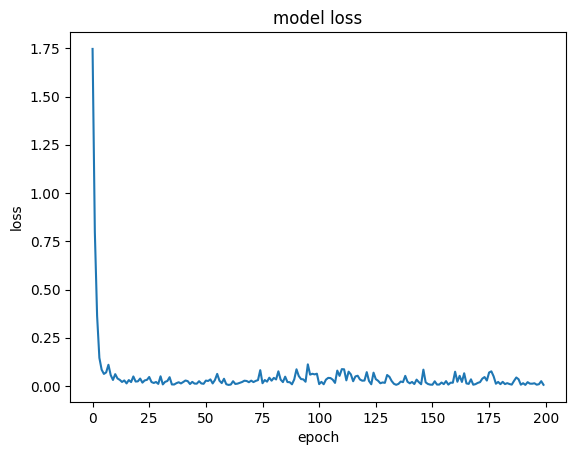

In [55]:
chatbot.train()

## Inference - Sinhala

In [56]:
chatbot_inf = ChatBot(language='si')
chatbot_inf.load_model_and_data()
# Interaction loop
while True:
    user_input = input("You: ")

    if user_input == 'q':
        break
    intents = chatbot_inf.predict_intent(user_input)
    print("Predicted Intents:", intents)
    if intents:
        response_intent = intents[0]
        response = chatbot_inf.generate_response(response_intent)
        print("Bot:", response)